In [2]:
# libraries
import numpy as np

In [3]:
#transition model
transition_model = np.array([0.7, 0.3])

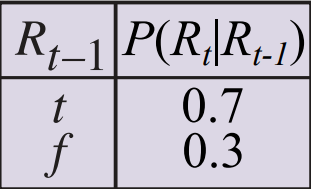

In [4]:
#sensor model
sensor_model = np.array([0.9, 0.2])


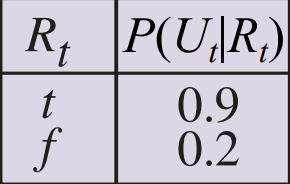

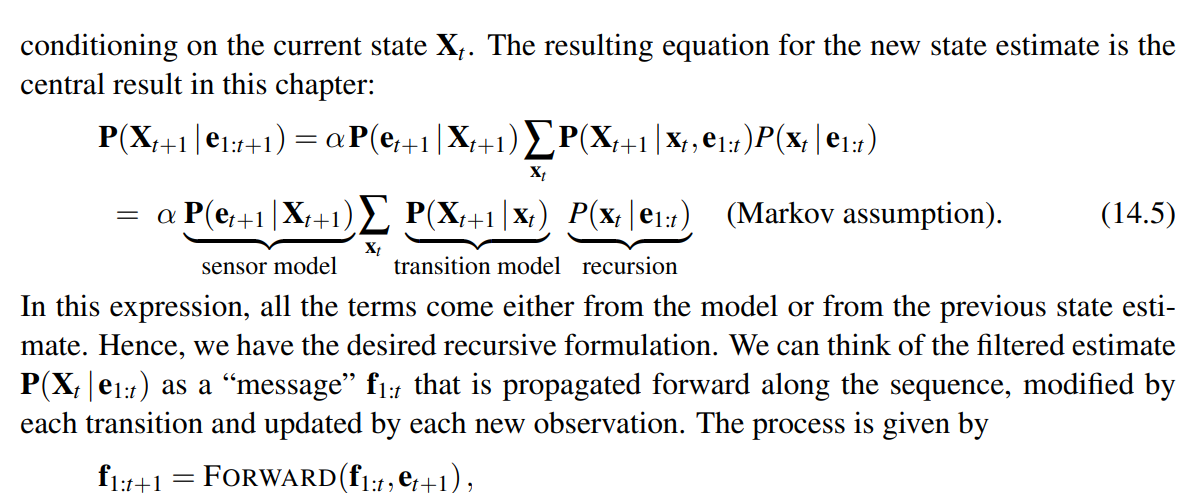
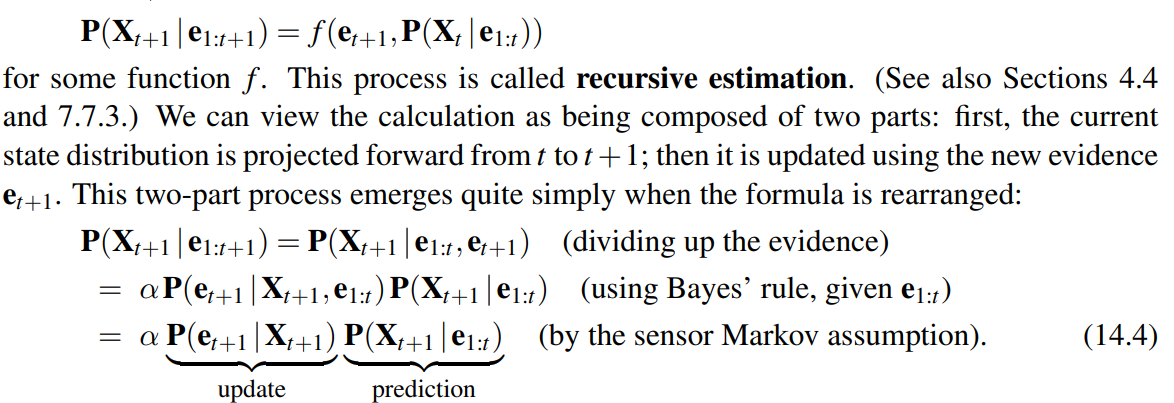
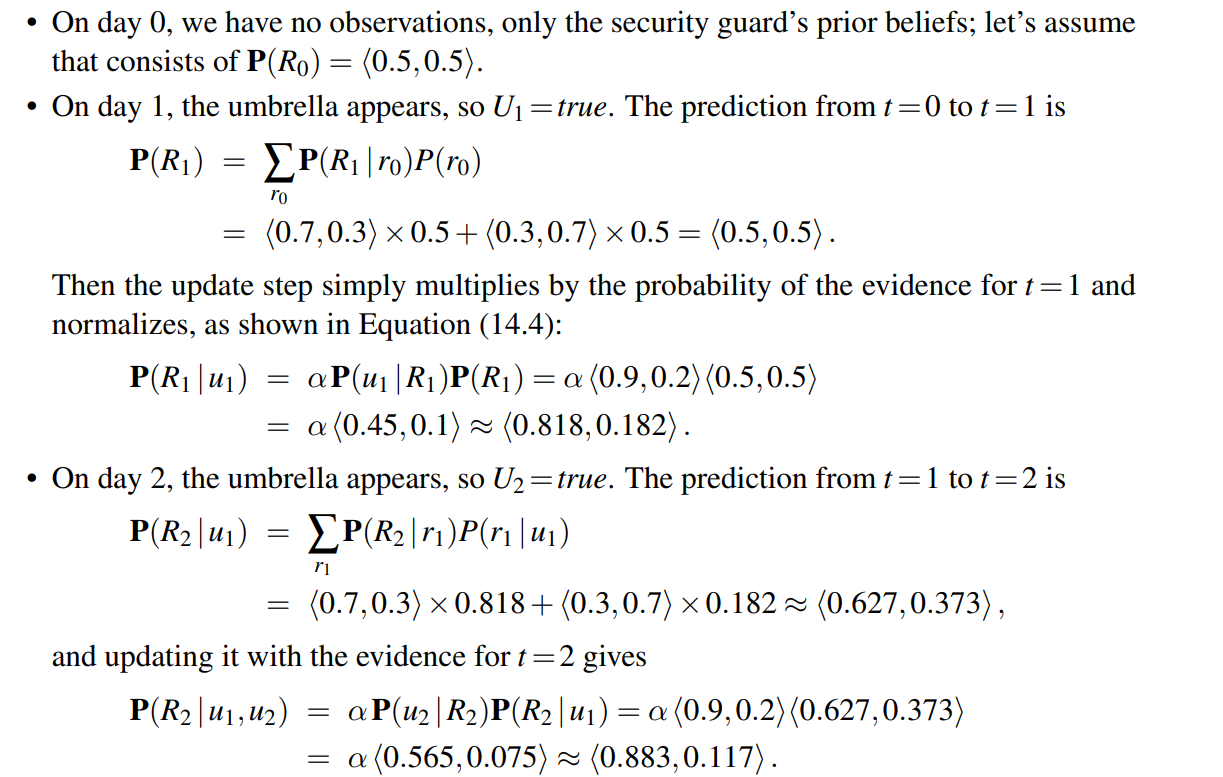

In [5]:
#filtering code based on the above calculation
#solution for this problem only, not general case

def normalize_pvectors(x):
    total = np.sum(x)
    return x / total

def filtering(evidences):
    px = np.array([0.5, 0.5]) #initial is 0.5 for each state

    t = len(evidences)

    for i in range(t):
        p_ri_lastu = transition_model * px[0] + transition_model[::-1] * px[1]
        p_ri_curu = sensor_model * p_ri_lastu #unnormalized
        p_ri_curu = normalize_pvectors(p_ri_curu)

        px = p_ri_curu
    return px

#Case 1: Day 1 
evidences = np.array([1])
print(filtering(evidences))

#Case 2: Day 2 
evidences = np.array([1, 1])
print(filtering(evidences))

[0.81818182 0.18181818]
[0.88335704 0.11664296]


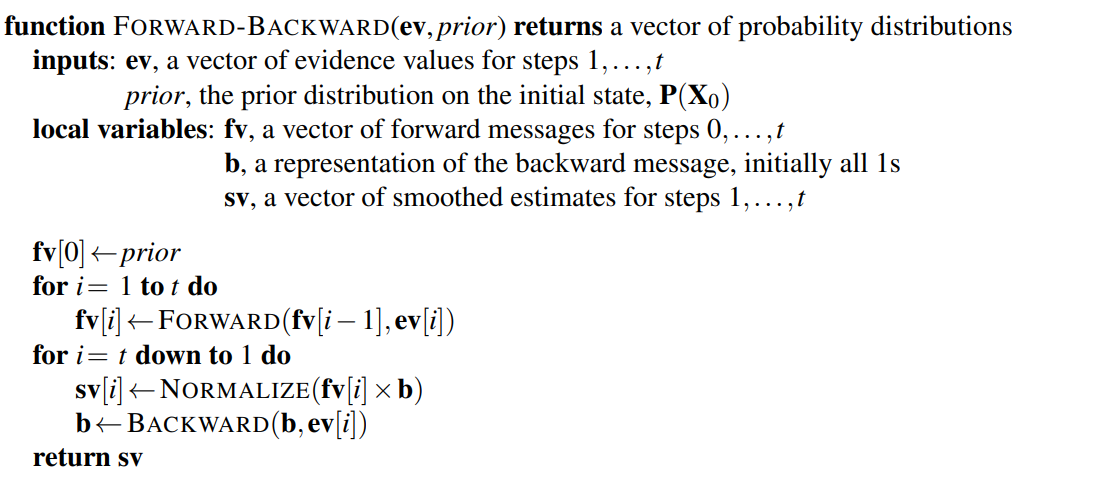
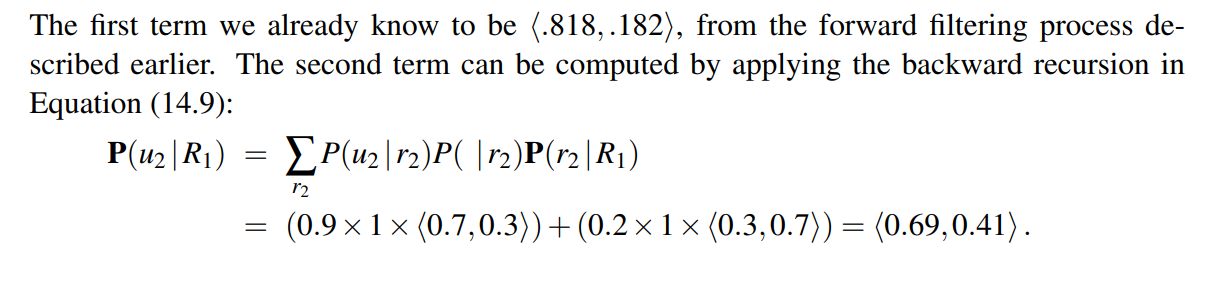
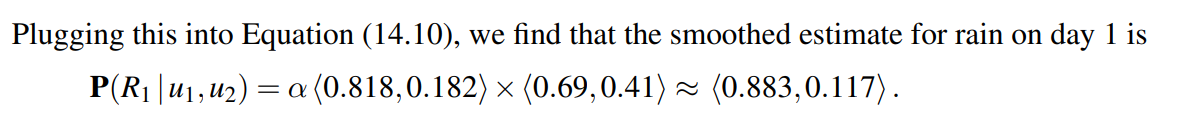

In [45]:
#forward-backward algorithm
#solution for this problem only, not general case!

def normalize_pvectors(x):
    total = np.sum(x)
    return x / total

def forward(f, e):
    # return normalize_pvectors(np.multiply(sensor_model, np.multiply(transition_model, f)))
    if e == 1:
        p = transition_model * f[0] + transition_model[::-1] * f[1]
    else:
        p = transition_model[::-1] * f[0] + transition_model * f[1]
    # return np.multiply(sensor_model, p)
    return normalize_pvectors(np.multiply(sensor_model, p)) if e == 1 else normalize_pvectors(np.multiply(1 - sensor_model, p))

def backward(b, e):
    if e == 1:
        p = sensor_model[0] * b[0] * transition_model + sensor_model[1] * b[1] * transition_model[::-1]
    else:
        p = (1 - sensor_model[1]) * b[0] * transition_model[::-1] + (1 - sensor_model[0]) * b[1] * transition_model
    return normalize_pvectors(p) 

def forward_backward(evidences):
    t = len(evidences)
    fv = np.zeros((t + 1, 2))
    fv[0] = np.array([0.5, 0.5])
    bv = np.ones((t + 1, 2))
    sv = fv.copy()
    
    for i in range(t):
        value = forward(fv[i], evidences[i])
        fv[i + 1] = value
    
    for i in range(t, 0, -1):
        sv[i] = normalize_pvectors(fv[i] * bv[i])
        bv[i - 1] = backward(bv[i], evidences[i - 1])
    return sv
evidences = np.array([1, 1, 0, 1])
print(forward_backward(evidences))

[[0.5        0.5       ]
 [0.85878528 0.14121472]
 [0.78681049 0.21318951]
 [0.10041041 0.89958959]
 [0.68409173 0.31590827]]


In [7]:
#Viterbi algorithm for finding the most likely state sequence for a evidence sequence
#In this example, I'll use state = [true, true, false, true, true]

#Warning!
#Multiplications of many probability value (0 <= px <= 1) may cause the result to underflow.
#This is the simplified version of viterbi algorithm made by me. The full version needs the input and output to be converted
#into matrix multiplication

def get_transition_value(cur_state, last_state):
    return transition_model[0] if cur_state == last_state else transition_model[1]

def get_sensor_value(cur_state, cur_evidence):
    if cur_evidence == 0:
        return 1 - sensor_model[0] if cur_state == 0 else 1 - sensor_model[1]
    else:
        return sensor_model[0] if cur_state == 0 else sensor_model[1]

def viterbi_algorithm(evidences):
    result = [[0.5], [0.5]]
    t = len(evidences)

    for i in range(t):
        last_p = [result[0][-1], result[1][-1]]
        for j1 in range(2):
            p_max = []
            for j2 in range(2):
                transition_value = get_transition_value(j1, j2)
                sensor_value = get_sensor_value(j1, evidences[i])

                # print(i, j1, transition_value, sensor_value)
                p_max.append(transition_value * sensor_value * last_p[j2])
            result[j1].append(max(p_max))

    return result

def probability_normalize(result):
    t = len(result)

    for i in range(t):
        total_p = result[0][i] + result[1][i]
        result[0][i] /= total_p
        result[1][i] /= total_p
    
    return result

In [8]:
evidences = np.array([1, 1, 0, 1, 1])
result = viterbi_algorithm(evidences)
print(result[0])
print(result[1])
# past_pe = np.array([0, 0, 1, 0, 0])
# print(probability_of_a_state(past_pe))
result = probability_normalize(result)

print(result[0])
print(result[1])

[0.5, 0.315, 0.19845000000000002, 0.013891499999999998, 0.012859560000000003, 0.008101522800000002]
[0.5, 0.06999999999999999, 0.0189, 0.047628000000000004, 0.00666792, 0.0009335087999999999]
[0.5, 0.8181818181818181, 0.19845000000000002, 0.013891499999999998, 0.012859560000000003, 0.008101522800000002]
[0.5, 0.1818181818181818, 0.0189, 0.047628000000000004, 0.00666792, 0.0009335087999999999]


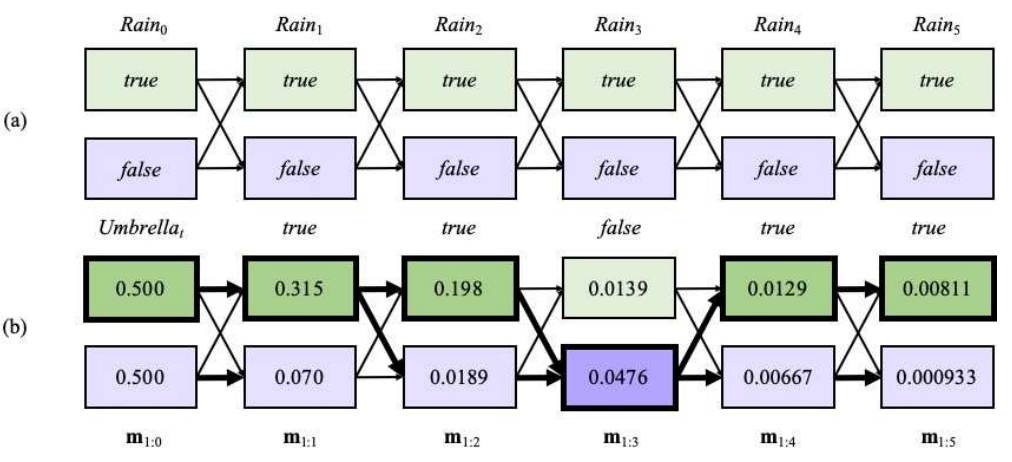
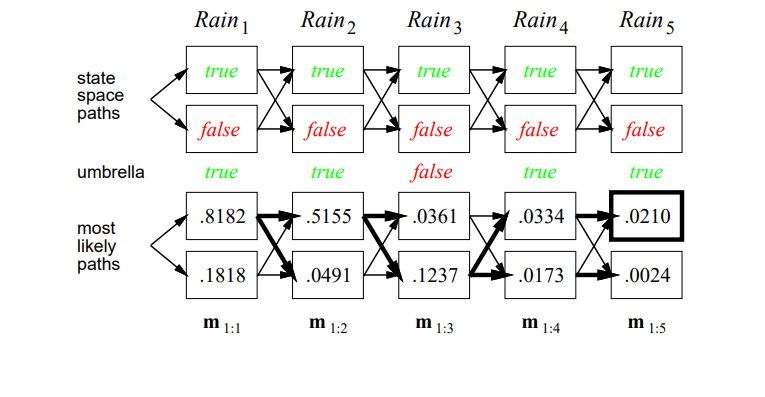

In [46]:
#forward-backward algorithm
#general case with matrix multiplication.

def normalize_pvectors(x):
    total = np.sum(x)
    return x / total

def forward_hmm(f, t, o):
    result = np.dot(o, t.T)
    result = np.dot(result, f)
    return normalize_pvectors(result)

def backward_hmm(b, t, o):
    result = np.dot(t, o)
    result = np.dot(result, b)
    return normalize_pvectors(result)

def forward_backward_hmm(evidences, transition_matrix, sensor_matrix):
    t = len(evidences)
    fv = np.zeros((t + 1, 2))
    fv[0] = np.array([0.5, 0.5])
    bv = np.ones((t + 1, 2))
    sv = fv.copy()

    for i in range(t):
        value = forward_hmm(fv[i], transition_matrix, sensor_matrix[1 - evidences[i]])
        fv[i + 1] = value

    for i in range(t, 0, -1):
        sv[i] = normalize_pvectors(fv[i] * bv[i])
        bv[i - 1] = backward_hmm(bv[i], transition_matrix, sensor_matrix[1 - evidences[i - 1]])
    return sv

def reverse_forward_hmm(f, t, o):
    result = np.dot(np.linalg.inv(t.T), np.linalg.inv(o))
    result = np.dot(result, f)
    return normalize_pvectors(result)

def forward_backward_hmm_no_memory(evidences, transition_matrix, sensor_matrix):
    t = len(evidences)
    fv = np.array([0.5, 0.5])
    bv = np.array([1., 1.])
    sv = np.zeros((t + 1, 2))
    sv[0] = np.array([0.5, 0.5])

    for i in range(t):
        fv = forward_hmm(fv, transition_matrix, sensor_matrix[1 - evidences[i]])

    for i in range(t, 0, -1):
        sv[i] = normalize_pvectors(fv * bv)
        fv = reverse_forward_hmm(fv, transition_matrix, sensor_matrix[1 - evidences[i - 1]])
        bv = backward_hmm(bv, transition_matrix, sensor_matrix[1 - evidences[i - 1]])

    return sv


transition_matrix = np.array([
    [0.7, 0.3],
    [0.3, 0.7]
])

sensor_matrix = np.array([
    [[0.9, 0],
    [0, 0.2]],
    [[0, 0.1],
    [0.8, 0]]
])

evidences = np.array([1, 1, 0, 1])

print(forward_backward(evidences))
print(forward_backward_hmm(evidences, transition_matrix, sensor_matrix))
print(forward_backward_hmm_no_memory(evidences, transition_matrix, sensor_matrix))

[[0.5        0.5       ]
 [0.85878528 0.14121472]
 [0.78681049 0.21318951]
 [0.10041041 0.89958959]
 [0.68409173 0.31590827]]
[[0.5        0.5       ]
 [0.85878528 0.14121472]
 [0.78681049 0.21318951]
 [0.10041041 0.89958959]
 [0.68409173 0.31590827]]
[[0.5        0.5       ]
 [0.85878528 0.14121472]
 [0.78681049 0.21318951]
 [0.10041041 0.89958959]
 [0.68409173 0.31590827]]


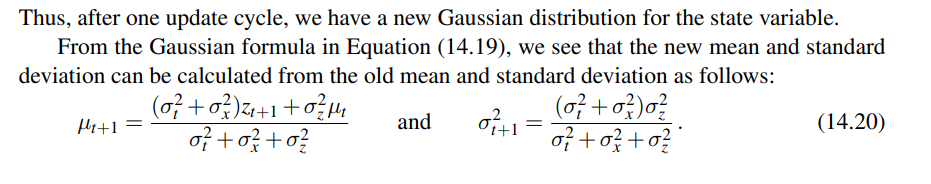

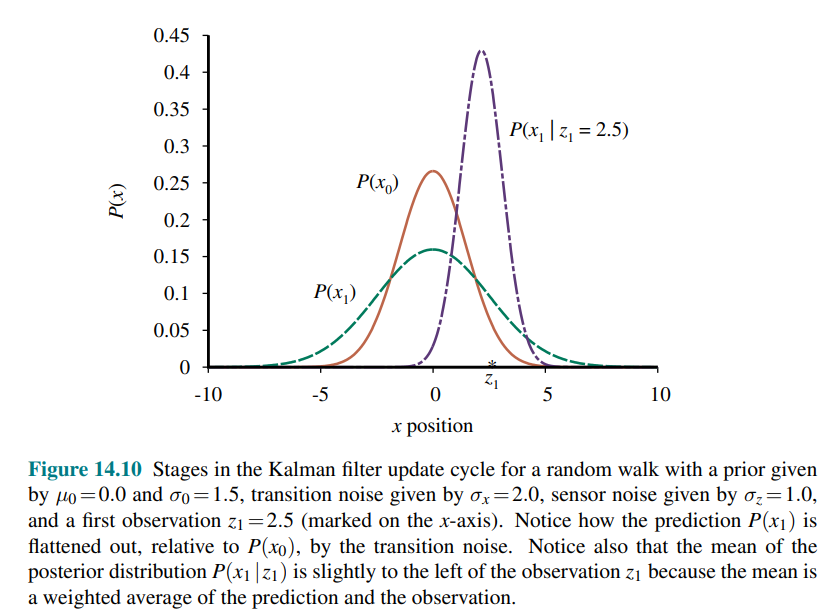
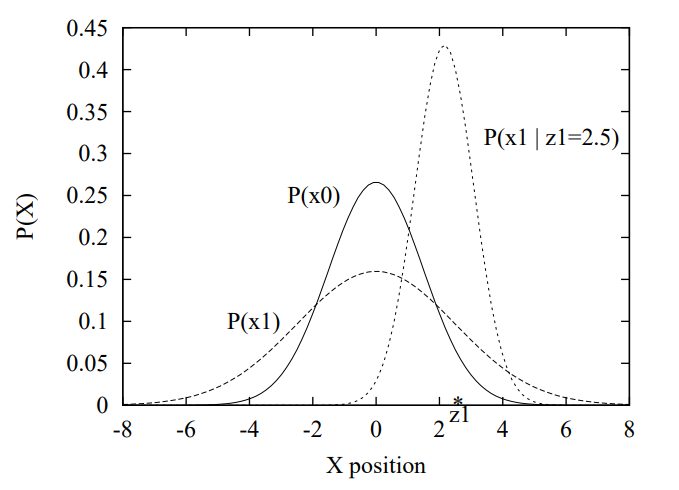

In [1]:
def cal_mean_of_next_step(o_t, o_x, z_t_1, o_z, u_t):
    return ((o_t ** 2 + o_x ** 2) * z_t_1 + o_z ** 2 * u_t) / (o_t ** 2 + o_x ** 2 + o_z ** 2)

def cal_std_of_next_step(o_t, o_x, o_z):
    return ((o_t ** 2 + o_x ** 2) * o_z ** 2) / (o_t ** 2 + o_x ** 2 + o_z ** 2)

u_t = 0.0
o_t = 1.5
o_x = 2.0
o_z = 1.0
z_t_1 = 2.5

print("Mean of next step: ", cal_mean_of_next_step(o_t, o_x, z_t_1, o_z, u_t))
print("STD of next step: ", cal_std_of_next_step(o_t, o_x, o_z))

Mean of next step:  2.1551724137931036
STD of next step:  0.8620689655172413


: 